[✓] Found saved COVID dataset at data/covid_brazil_combined.csv. Loading it...
Epoch 0: Train Loss = 1.6149 | LR = 0.001000
Epoch 10: Train Loss = 0.8478 | LR = 0.001000
Epoch 20: Train Loss = 0.7650 | LR = 0.001000
Epoch 30: Train Loss = 0.7034 | LR = 0.001000
Epoch 40: Train Loss = 0.6421 | LR = 0.001000
Epoch 50: Train Loss = 0.6232 | LR = 0.000500
Epoch 60: Train Loss = 0.5946 | LR = 0.000500
Epoch 70: Train Loss = 0.6012 | LR = 0.000500
Epoch 80: Train Loss = 0.5722 | LR = 0.000500
Epoch 90: Train Loss = 0.5667 | LR = 0.000500
Epoch 100: Train Loss = 0.5891 | LR = 0.000250
Epoch 110: Train Loss = 0.5608 | LR = 0.000250
Epoch 120: Train Loss = 0.5401 | LR = 0.000250
Epoch 130: Train Loss = 0.5391 | LR = 0.000250
Epoch 140: Train Loss = 0.5507 | LR = 0.000250
Epoch 150: Train Loss = 0.5248 | LR = 0.000125
Epoch 160: Train Loss = 0.5419 | LR = 0.000125
Epoch 170: Train Loss = 0.5276 | LR = 0.000125
Epoch 180: Train Loss = 0.5418 | LR = 0.000125
Epoch 190: Train Loss = 0.5416 | LR = 0

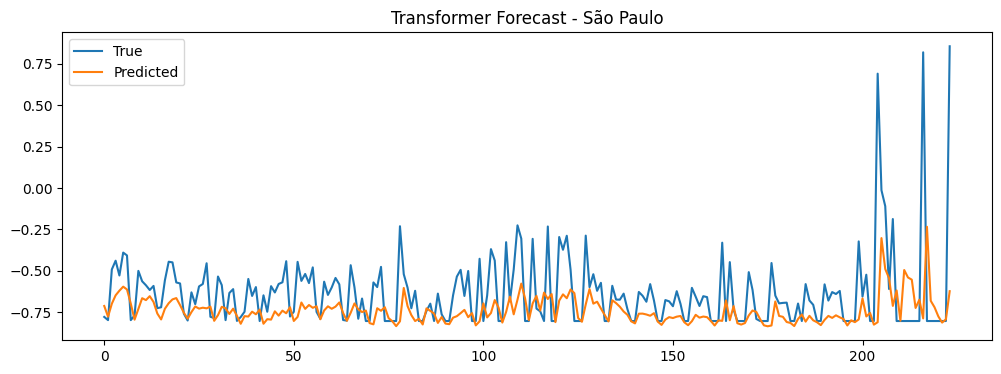

In [21]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from codes.load_and_save_covid_data import load_and_save_covid_data
from codes.data_utils import set_seed

set_seed(42)

# Load data
covid_df = load_and_save_covid_data()
covid_df['date'] = pd.to_datetime(covid_df['date'])

# Filter São Paulo (IBGE: 3550308)
sp = covid_df[covid_df['ibgeID'] == 3550308].sort_values('date')
data = sp['newCases'].fillna(0).values.astype(np.float32)

# Normalize
data = (data - data.mean()) / (data.std() + 1e-6)

# Sequence config
window_size = 14

def create_sequences(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return torch.tensor(X), torch.tensor(y)

# Split train/test
split_idx = int(0.8 * len(data))
train_data = data[:split_idx]
test_data = data[split_idx - window_size:]  # include overlap

X_train, y_train = create_sequences(train_data, window_size)
X_test, y_test = create_sequences(test_data, window_size)

# Add batch and feature dimension
X_train = X_train.unsqueeze(-1)  # [batch, seq_len, 1]
X_test = X_test.unsqueeze(-1)

# Define simple transformer
class SimpleTransformer(nn.Module):
    def __init__(self, d_model=64, nhead=4, num_layers=1, dropout=0.2):
        super().__init__()
        self.input_linear = nn.Linear(1, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(1, window_size, d_model))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, batch_first=True, dropout=dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.dropout = nn.Dropout(dropout)
        self.bn = nn.BatchNorm1d(d_model)
        self.output = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_linear(x) + self.pos_embedding  # [B, T, D]
        x = self.dropout(x)
        
        x = self.transformer(x)  # [B, T, D]
        x = x[:, -1, :]  # Last timestep output: [B, D]

        x = self.bn(x)  # Apply BatchNorm over features
        x = self.dropout(x)
        return self.output(x).squeeze()


# Model, loss, optimizer
model = SimpleTransformer()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# StepLR: decay LR by gamma every step_size epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)


epochs = 200
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    pred = model(X_train)
    loss = loss_fn(pred, y_train)
    loss.backward()
    optimizer.step()
    scheduler.step()

    if epoch % 10 == 0:
        current_lr = scheduler.get_last_lr()[0]
        print(f"Epoch {epoch}: Train Loss = {loss.item():.4f} | LR = {current_lr:.6f}")


# Evaluation
model.eval()
with torch.no_grad():
    pred_test = model(X_test).detach().numpy()
    true_test = y_test.numpy()
    rmse = np.sqrt(mean_squared_error(true_test, pred_test))
    print(f"\nTest RMSE: {rmse:.4f}")

    # Optional: plot
    plt.figure(figsize=(12, 4))
    plt.plot(true_test, label="True")
    plt.plot(pred_test, label="Predicted")
    plt.legend()
    plt.title("Transformer Forecast - São Paulo")
    plt.show()
